In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import wandb
from ff import FF, FFLayer
from data import MNIST
from tqdm import tqdm

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
batch_size_train = 512
batch_size_test = 512

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./datasets/MNIST/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

In [5]:
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./datasets/MNIST/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [6]:
threshold = 1.5
epochs = 50
model = FF(logging=False, device=device)
optim_config = {
    "lr": 0.01,
}
positive_optim_config = {
    "lr": 0.005,

}
negative_optim_config = {
    "lr": 0.01,
}
model.add_layer(FFLayer(nn.Linear(784, 500).to(device), optimizer=torch.optim.Adam, epochs=epochs, threshold=threshold, activation=nn.ReLU(), optim_config=optim_config, positive_optim_config=positive_optim_config, negative_optim_config=negative_optim_config, logging=False, name="layer 1").to(device))
model.add_layer(FFLayer(nn.Linear(500, 500).to(device), optimizer=torch.optim.Adam, epochs=epochs, threshold=threshold, activation=nn.ReLU(), optim_config=optim_config, positive_optim_config=positive_optim_config, negative_optim_config=negative_optim_config, logging=False, name="layer 2").to(device))
model.add_layer(FFLayer(nn.Linear(500, 500).to(device), optimizer=torch.optim.Adam, epochs=epochs, threshold=threshold, activation=nn.ReLU(), optim_config=optim_config, positive_optim_config=positive_optim_config, negative_optim_config=negative_optim_config, logging=False, name="layer 3").to(device))

# Training

In [7]:
# wandb.init(project="MNIST", entity="ffalgo")
# wandb.config = {
#   "learning_rate": 0.01,
#   "epochs": 50,
#   "batch_size": 32,
#   "activation": "relu",
#   "positive_lr": 0.005,
#   "negative_lr": 0.005,
#   "threshold": threshold,
#   "optimizer": torch.optim.Adam,
#   "device": device
# }

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/500 [00:00<?, ?it/s]

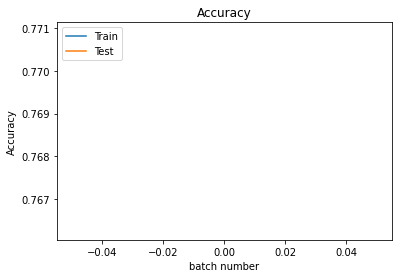

  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 0/500 [00:39<?, ?it/s]


In [8]:
import matplotlib.pyplot as plt

model = model.to(device)
epochs = 500
best_acc = 0.0
accuracies_train = []
accuracies_test = []
for i in tqdm(range(epochs)):
        

    # wandb.log({"Accuracy on train data": acc})    
    model.train()

    for i, (x, y) in enumerate(train_loader):
        x_pos, _ = MNIST.overlay_y_on_x(x, y)
        rnd = torch.randperm(x.size(0))
        x_neg, _ = MNIST.overlay_y_on_x(x, y[rnd])
        x_pos, x_neg = x_pos.to(device), x_neg.to(device)
        model.forward(x_pos, x_neg)
        
        if i % 10 == 9:
            predictions, real = MNIST.predict(train_loader, model, device)
            acc_train = np.sum(predictions == real)/len(real)

            predictions, real = MNIST.predict(test_loader, model, device)
            acc_test = np.sum(predictions == real)/len(real)


            accuracies_train.append(acc_train)
            accuracies_test.append(acc_test)

            plt.plot(accuracies_train)
            plt.plot(accuracies_test)
            plt.title('Accuracy')
            plt.ylabel('Accuracy')
            plt.xlabel('batch number')
            plt.legend(['Train', 'Test'], loc='upper left')
            plt.show()